# Sentiment Analysis of WA Messages

## Imports and utility functions

In [61]:
from google.cloud import bigquery
from google.oauth2 import service_account
from pandas_gbq import read_gbq
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# Path to your service account key file
key_path = r"C:\Users\ricjar\Documents\json_credentials.txt"

# Create a credentials object
credentials = service_account.Credentials.from_service_account_file(key_path)

## Data Extraction from BQ

In [63]:
# Extracción de datos desde BigQuery
def extract_data_from_bigquery(credentials, query):
    
    # Your project ID
    project_id = 'test-discovery-sybxsf'
    
    # Read data from BigQuery into a pandas dataframe
    df = read_gbq(query, project_id=project_id, credentials=credentials)
    return df

In [64]:
query = """
    SELECT
        DATETIME(dt, 'America/Mexico_City') fecha
        ,user
        --,name
        --,JSON_EXTRACT_SCALAR(payload, '$.flujo') flujo
        --,JSON_EXTRACT_SCALAR(payload, '$.etapa') etapa
        --,JSON_EXTRACT_SCALAR(payload, '$.pregunta') pregunta
        ,JSON_EXTRACT_SCALAR(payload, '$.respuesta') respuesta
    FROM `test-discovery-sybxsf.SQUADS.events`
    WHERE _partitiontime >= '2024-12-30'
    AND DATETIME(dt, 'America/Mexico_City') >= '2025-01-01'
    AND bot = 'lbwbdtur'
    AND JSON_EXTRACT_SCALAR(payload, '$.flujo') = 'not understood'
    AND JSON_EXTRACT_SCALAR(payload, '$.respuesta') IS NOT NULL
    AND JSON_EXTRACT_SCALAR(payload, '$.respuesta') != ''
    ORDER BY 1,name
"""

df = extract_data_from_bigquery(query=query, credentials=credentials)
# df.head(5)

Downloading: 100%|██████████|


In [65]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max
fecha,25225,NaN,NaN,NaN,2025-02-16 13:44:18.315877,2025-01-01 01:48:25,2025-01-31 14:04:58,2025-02-05 13:40:07,2025-03-01 09:39:56,2025-04-15 16:15:09
user,25225,9032,01JJV1YAGG025ZWE6PJ7BSFT19,917,NaN,NaN,NaN,NaN,NaN,NaN
respuesta,25225,16711,Por favor... ¿Puedes ayudarme a ganar 4 obsequ...,641,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df[df.isna().any(axis=1)].shape  # Verificar si hay valores nulos

(0, 3)

### Response examples

In [67]:
def select_random_rows(df, n=10):
    """
    Selects n random rows from the dataframe.
    """

    df_sample = df.copy()
    df_sample = df.sample(n+1).reset_index()
    
    for i in range(1,n+1):
        for col in df_sample.columns:
            print(f'{col}: {df_sample.iloc[i][col]}')
        print('---')

In [68]:
n = 5

select_random_rows(df[['respuesta']], n)

index: 5069
respuesta: Yh
---
index: 10970
respuesta: Por favor
---
index: 19941
respuesta: Lo que es es bueno
---
index: 15913
respuesta: CHNEDLEA2L
---
index: 9245
respuesta: Hhjgfkfiñ🍔🍳
---


## Preprocessing

In [69]:
# Preprocesamiento del texto
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'https?://\S+', '*url*', text)  # Reemplazar URLs
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remover signos de puntuación
    text = re.sub(r'[^a-zA-Z0-9áéíóúñ ]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r"\d+", "", text)  # Remover números
    text = text.strip()

    return text

In [70]:
df['preprocessed'] = df['respuesta'].apply(preprocess_text)
select_random_rows(df[['respuesta', 'preprocessed']], n)

index: 1379
respuesta: No
preprocessed: no
---
index: 22057
respuesta: Ejhhehf
preprocessed: ejhhehf
---
index: 10271
respuesta: Nada
preprocessed: nada
---
index: 21421
respuesta: Que
preprocessed: que
---
index: 1900
respuesta: Pooollllooooooooooooo
preprocessed: pooollllooooooooooooo
---


## Generate labels

### Regex (Baseline)

In [71]:
def generate_labels_regexp(df, column, label_name='label'):
    
    def label_text(text):
        text = str(text).lower().strip()
        
        if re.search(r'url|http[s]?|spam|link|temu|gana hasta|ayuda[r]?me a ganar|@|gratis', text) or len(text) >= 100:
            return "spam"
        elif re.search(r'[vb]erg[oa]|put[oa]s?\b|pinche|guey|wey|malo|tonto|idiota|est[u]úpido|chinga|tu madre|c[áa]llate|culer[oa]|mierda|pendej[oa]|mamad[oa]|mame[sn]|porno|m[ée]tetelo|pene|vagina', text):
            return "grosero"
        elif re.search(r'qui[ée]n ere|\bme voy\b|no me interesa|molest[oa]|bloque[oa]|no quiero|no kiero|\bsalir\b|\badi[oó]s\b|no gracias|nada|nunca|descansando|d[eé]j(ame|enme)', text):
            return "no interesado"
        elif re.search(r'informaci[oó]n|disc[uú]lpe|buen (d[ií]a|noche)|canjea[r]?|canjea|tira|ticket|empaque|bolsa|\bsí\b|me interesa|s[ií] gracias|c[oó]mo puedo|participar|listo|hol[as]|c[oó]mo consigo', text):
            return "interesado"
        
        else:
            return "otro"

    df[label_name] = df[column].apply(label_text)
    return df

In [72]:
def plot_label_distribution_and_pie_chart(df, label_column, ignore_columns=[]):
    """
    Plots the distribution of labels in the dataframe in ascending order and a pie chart in a single subplot.
    """

    # Exclude specified columns
    df_filtered = df[~df[label_column].isin(ignore_columns)]

    # Create a figure with 1x2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Pie chart for label distribution
    label_counts = df_filtered[label_column].value_counts()
    label_counts.plot.pie(
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(label_counts)), ax=axes[0]
    )
    axes[0].set_title('Distribución de etiquetas', fontweight='bold')
    axes[0].set_ylabel('')  # Remove y-axis label for better visualization
    
    # Bar plot for label distribution
    order = df_filtered[label_column].value_counts(ascending=True).index
    sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])
    axes[1].set_title('Conteo de etiquetas', fontweight='bold')
    axes[1].set_xlabel('Etiqueta')
    axes[1].set_ylabel('Frecuencia')
    axes[1].tick_params(axis='x', rotation=45)

    

    # Adjust layout
    plt.tight_layout()
    plt.show()

index: 13043
respuesta: https://youtu.be/MP-RHIyWjXA?si=2F21aQBxySFRcB7C
preprocessed: url
label: spam
---
index: 19623
respuesta: https://temu.com/s/HGe2FkcJPG72xXU
preprocessed: url
label: spam
---
index: 21131
respuesta: https://www.radio-en-vivo.mx/super-981
preprocessed: url
label: spam
---
index: 15461
respuesta: https://marketplace.minecraft.net/en-us/pdp?id=aeb01ded-3fc3-4868-aa92-26215aefa7b8
preprocessed: url
label: spam
---
index: 23262
respuesta: https://www.facebook.com/share/r/1ECxArdcBi/
preprocessed: url
label: spam
---


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


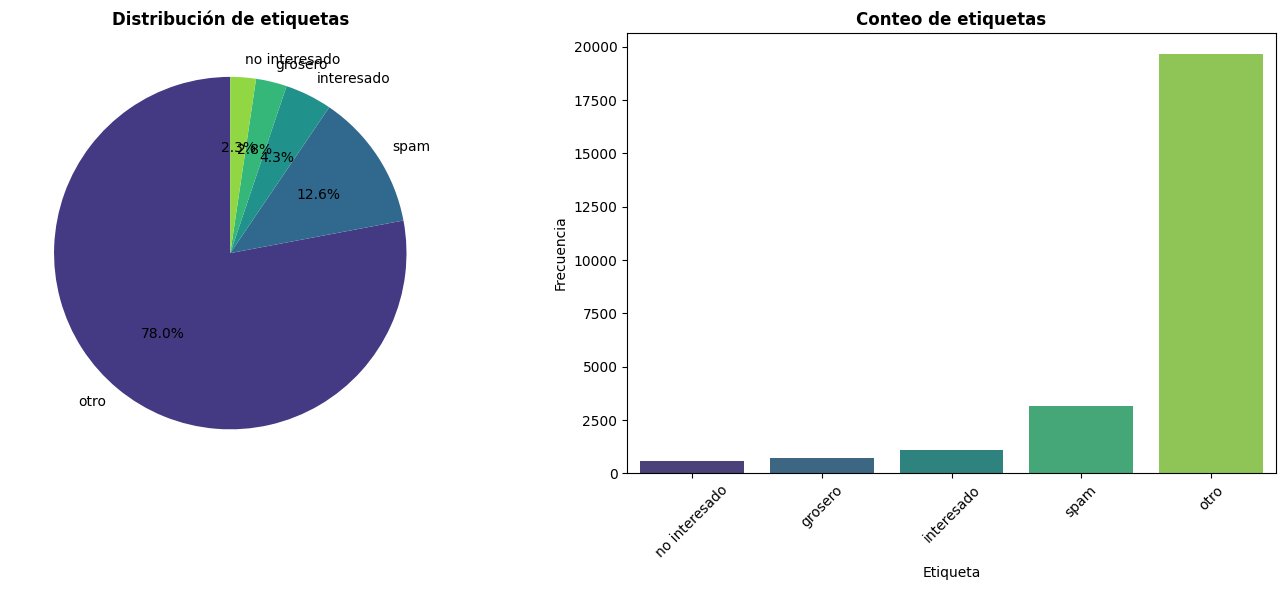

In [73]:
label_name = 'label'

# 1. Generate labels using regex
df = generate_labels_regexp(df, 'preprocessed', label_name=label_name)
# 2. Select random rows to check the labels
select_random_rows(df[df[label_name] != 'otro'][['respuesta', 'preprocessed', label_name]], n)
# 3. Plot label distribution and pie chart
plot_label_distribution_and_pie_chart(df, label_name)

In [74]:
# 4. Select random rows for specific labels
select_random_rows(df[df[label_name] == 'spam'][['respuesta', label_name]], n)

index: 19062
respuesta: https://vm.tiktok.com/ZMB1SEgCe/
label: spam
---
index: 22735
respuesta: Owiepwiewpieowieeoirwpieowieryeoiepwpwufwoiewpieowuro2ueoeirurpeurwpdjdlfjldfjldkdhfskhxabxmzbxmxnc BC znbzxmnxmz
label: spam
---
index: 19746
respuesta: https://www.facebook.com/share/r/1Dcy9ZqKdk/
label: spam
---
index: 18876
respuesta: https://youtu.be/hmytf4WazgU?si=Dqhz3wgDln_KCPYX
label: spam
---
index: 17158
respuesta: Por favor... ¿Puedes ayudarme a ganar 4 obsequios? Absolutamente sí
https://temu.com/s/DNdBTGzkcMBTjNB
label: spam
---


### K-Means

In [75]:
# Generación automática de etiquetas con clustering
def generate_labels_kmeans(df, column, label_name='label_k', n_clusters=5):
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df[column])
    
    model = KMeans(n_clusters=n_clusters, random_state=42)
    df[label_name] = model.fit_predict(X)
    return df, model, vectorizer

index: 1555
respuesta: Y naciones
preprocessed: y naciones
label_k: 1
---
index: 10927
respuesta: B
preprocessed: b
label_k: 1
---
index: 9922
respuesta: Feo
preprocessed: feo
label_k: 1
---
index: 23525
respuesta: D
o,😉⬛🎉😭⬛😭😭😭😭😥😭😉😭😭🎉🎉😥🎉🩴🎉🟪🟪🟪🎉🌿💧💧🤐😭
preprocessed: do
label_k: 1
---
index: 564
respuesta: CHABNM4EJ
preprocessed: chabnmej
label_k: 1
---


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


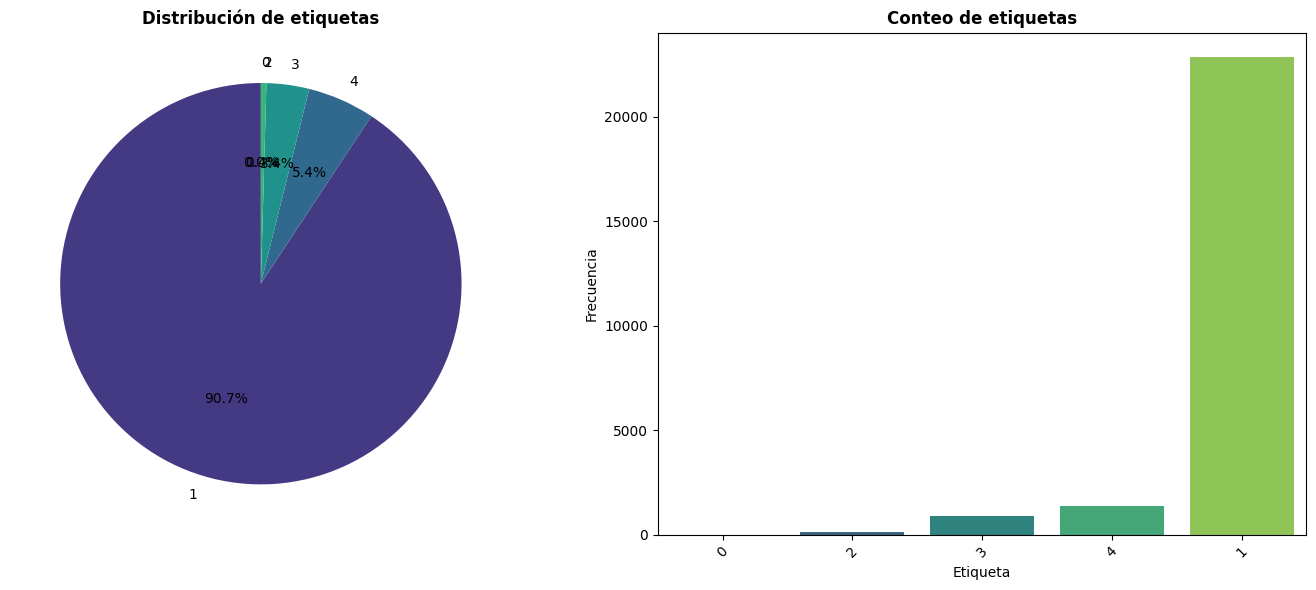

In [76]:
label_name = 'label_k'

# 1. Generate labels using kmeans
df, _, _ = generate_labels_kmeans(df, 'preprocessed', label_name=label_name, n_clusters=5)
# 2. Select random rows to check the labels
select_random_rows(df[df[label_name] != 'otro'][['respuesta', 'preprocessed', label_name]], n)
# 3. Plot label distribution and pie chart
plot_label_distribution_and_pie_chart(df, label_name)

In [77]:
# 4. Select random rows for specific labels
select_random_rows(df[df[label_name] == 1][['respuesta', label_name]], n)

index: 15629
respuesta: .
label_k: 1
---
index: 13712
respuesta: M
label_k: 1
---
index: 4766
respuesta: Sizckzkxxk1
label_k: 1
---
index: 23992
respuesta: SaladitasCuaresma cñkd
label_k: 1
---
index: 9745
respuesta: Yiriyyy8rl7k5e
label_k: 1
---


## Naive Bayes Classifier for generalization

### Train-Test Split and Model Training

In [78]:
def train_and_predict(df, x_label, y_label, label_name='y_pred'):
    
    # Text vectorization
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df[x_label])
    y = df[y_label]  # Etiquetas (en este caso, label_name)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predictions
    df[label_name] = model.predict(X)
    df['correct'] = df[y_label] == df[label_name]

    # Probability scores
    probas = model.predict_proba(X)
    # Get the maximum probability for each sample
    df[f'{label_name}_proba'] = probas.max(axis=1)
    # Get the predicted class for each sample
    class_names = model.classes_
    for i, class_name in enumerate(class_names):
        df[f'proba_{class_name}'] = probas[:, i]

    return df, model, vectorizer, X_train, X_test, y_train, y_test

index: 8352
respuesta: Haces que venga algo?
preprocessed: haces que venga algo
label: otro
label_nb: otro
---
index: 6366
respuesta: Dduddjduxjffhfkfjefftjf
preprocessed: dduddjduxjffhfkfjefftjf
label: otro
label_nb: otro
---
index: 6083
respuesta: Quieres una cogida
preprocessed: quieres una cogida
label: otro
label_nb: otro
---
index: 24915
respuesta: Puntos
preprocessed: puntos
label: otro
label_nb: otro
---
index: 11452
respuesta: Vx
preprocessed: vx
label: otro
label_nb: otro
---


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


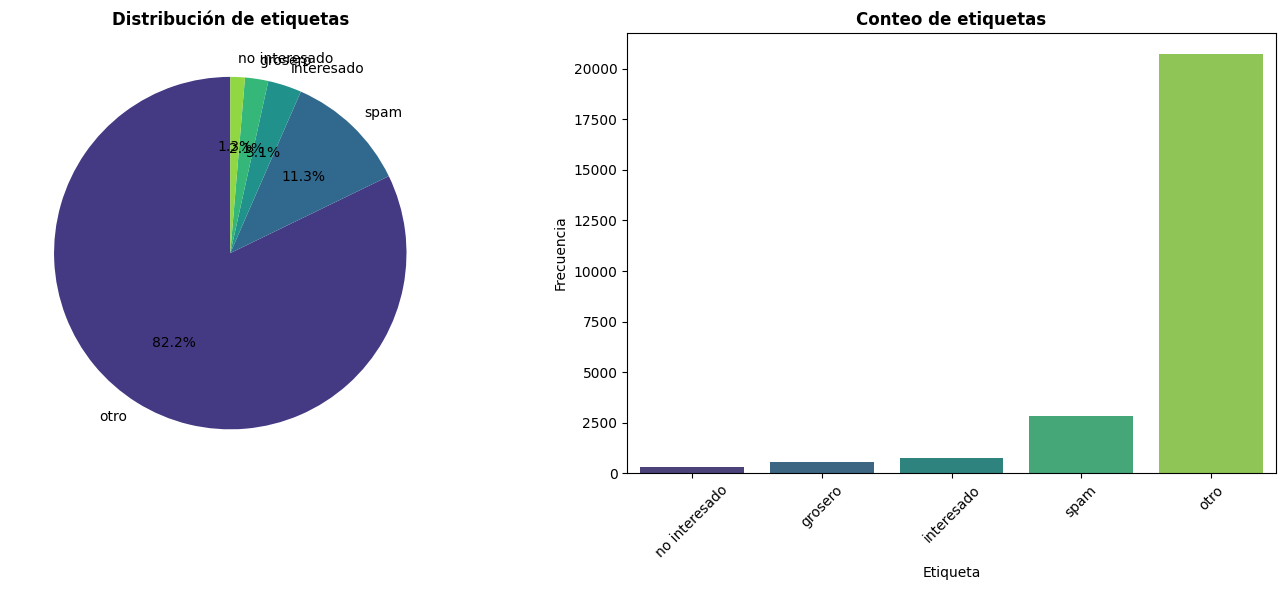

In [79]:
label_name = 'label_nb'
y_label = 'label'

# 1. Train and predict labels using Naive Bayes
df, model, vectorizer, X_train, X_test, y_train, y_test = train_and_predict(df, 'preprocessed', y_label, label_name=label_name)
# 2. Select random rows to check the labels
select_random_rows(df[['respuesta', 'preprocessed', y_label, label_name]], n)
# 3. Plot label distribution and pie chart
plot_label_distribution_and_pie_chart(df, label_name) #, ignore_columns=['otro'])

In [80]:
# 4. Select random rows for specific labels
select_random_rows(df[df[label_name] == 'grosero'][['respuesta', y_label, label_name]], n)

index: 7686
respuesta: Ya chinga tu madre
label: grosero
label_nb: grosero
---
index: 7745
respuesta: Coma mierda
label: grosero
label_nb: grosero
---
index: 2861
respuesta: chinga tu madre
label: grosero
label_nb: grosero
---
index: 7564
respuesta: Pinche mamon
label: grosero
label_nb: grosero
---
index: 25072
respuesta: Ya vete ala verga
label: grosero
label_nb: grosero
---


In [81]:
df.head(5)

,fecha,user,respuesta,preprocessed,label,label_k,label_nb,correct,label_nb_proba,proba_grosero,proba_interesado,proba_no interesado,proba_otro,proba_spam
0,2025-01-01 01:48:25,01JFP8JG8DJ5S2MF5G20Y1VKRH,Ya no gracias,ya no gracias,no interesado,1,otro,False,0.926432,0.003615,0.004848,0.060258,0.926432,0.004847
1,2025-01-01 02:54:12,01JD2QC03T3R0Q7JVWCC8RJWDT,Estados Unidos y estados miembros y xked Cleme...,estados unidos y estados miembros y xked cleme...,spam,1,spam,True,0.984901,0.004781,0.002170,0.003612,0.004536,0.984901
2,2025-01-01 02:54:12,01JD2QC03T3R0Q7JVWCC8RJWDT,Estados Unidos y estados miembros y xked Cleme...,estados unidos y estados miembros y xked cleme...,spam,1,spam,True,0.984901,0.004781,0.002170,0.003612,0.004536,0.984901
3,2025-01-01 02:54:13,01JD2QC03T3R0Q7JVWCC8RJWDT,País donde están los de naciones miembros del ...,país donde están los de naciones miembros del ...,spam,1,spam,True,0.992902,0.000393,0.000371,0.000263,0.006071,0.992902
4,2025-01-01 02:54:13,01JD2QC03T3R0Q7JVWCC8RJWDT,País donde están los de naciones miembros del ...,país donde están los de naciones miembros del ...,spam,1,spam,True,0.992902,0.000393,0.000371,0.000263,0.006071,0.992902


In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20180, 1000), (5045, 1000), (20180,), (5045,))

### Model evaluation

In [83]:
def plot_classification_report(y_test, y_pred, class_names):
    """
    Plots the classification report as a heatmap.
    """
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

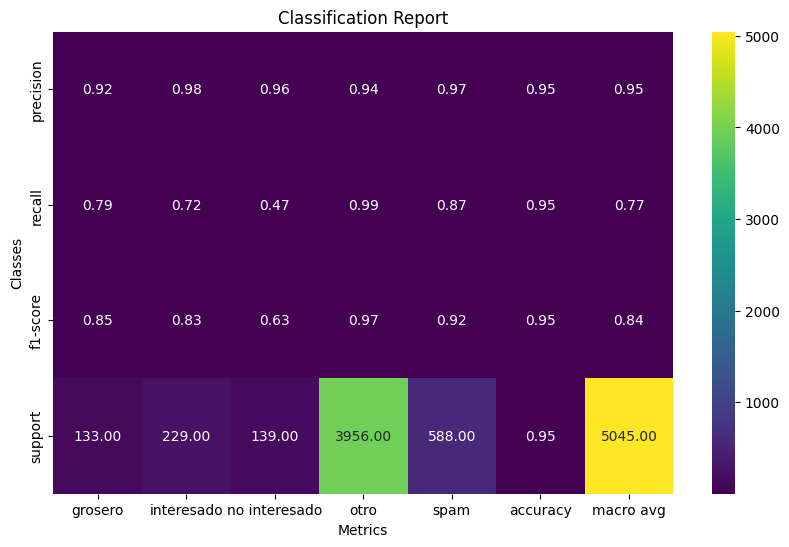

In [84]:
plot_classification_report(y_test=y_test, y_pred=model.predict(X_test), class_names=model.classes_)

Result interpretation
---

📌 Clase: "grosero"
---
Precision: 0.99 → De todos los que el modelo predijo como groseros, acertó el 99%.

Recall: 0.75 → De todos los mensajes realmente groseros, el modelo solo identificó el 75%.

F1: 0.85 → Buen balance, pero podría mejorar el recall (está perdiendo groserías).

Support: 124 → Había 124 mensajes groseros en total.

🔎 Conclusión: El modelo es muy confiado, pero deja pasar groserías reales (quizá no tiene suficientes ejemplos o son más variadas).

📌 Clase: "interesado"
---
Precision: 0.98, Recall: 0.70, F1: 0.82, Support: 238

📌 Conclusión: Similar al caso anterior. El modelo acierta casi siempre cuando dice “interesado”, pero a veces no detecta usuarios interesados (recall bajo). F1-score razonable.

📌 Clase: "no interesado"
---
Precision: 0.92, Recall: 0.51, F1: 0.65, Support: 136

🔴 Problema: Este es tu punto débil. Está detectando solo el 51% de los "no interesados". Podría estar confundiendo estos mensajes con neutros o spam.

📌 Clase: "otro"
---
Precision: 0.94, Recall: 1.00, F1: 0.97, Support: 3920

✅ Conclusión: Excelente recall: todo lo que era "otro", lo identificó bien. Tal vez está usando "otro" como clase comodín — vale la pena revisar si no estás sobreusando esta clase.

📌 Clase: "spam"
---
Precision: 0.98, Recall: 0.86, F1: 0.92, Support: 613

✔️ Conclusión: Buen rendimiento general. Aunque podrías mejorar un poco el recall si hay mensajes de spam que se le escapan.

📊 Global
---
Accuracy: 0.95 → 95% de predicciones correctas en general.

Macro avg (F1-score): 0.84 → El promedio balanceado de F1 es bueno, aunque penalizado por la clase "no interesado".

In [85]:
# from sklearn.metrics import roc_curve, roc_auc_score

# import matplotlib.pyplot as plt

# # Binarize the labels for ROC and AUC
# y_test_binarized = pd.get_dummies(y_test)
# y_pred_proba = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_)

# # Plot ROC curve for each class
# plt.figure(figsize=(10, 8))
# for class_name in model.classes_:
#     fpr, tpr, _ = roc_curve(y_test_binarized[class_name], y_pred_proba[class_name])
#     auc_score = roc_auc_score(y_test_binarized[class_name], y_pred_proba[class_name])
#     plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

# plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
# plt.title("ROC Curve")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.grid()
# plt.show()


In [86]:
incorrect_label = 'no interesado'

mask = (df['correct'] == False) & (df['label'] == incorrect_label)
df[mask].head(5)

,fecha,user,respuesta,preprocessed,label,label_k,label_nb,correct,label_nb_proba,proba_grosero,proba_interesado,proba_no interesado,proba_otro,proba_spam
0,2025-01-01 01:48:25,01JFP8JG8DJ5S2MF5G20Y1VKRH,Ya no gracias,ya no gracias,no interesado,1,otro,False,0.926432,0.003615,0.004848,0.060258,0.926432,0.004847
126,2025-01-02 20:29:08,01JGMYN738K42JQC3Z27AMRJQ0,No quiero nd ya,no quiero nd ya,no interesado,1,otro,False,0.947316,0.004635,0.013252,0.032326,0.947316,0.002472
209,2025-01-03 18:09:19,01JGQ9PE5RHVJ1STVPEHYMFVYM,Ya no quiero hacer nada...porque no tengo tiem...,ya no quiero hacer nadaporque no tengo tiempo ...,no interesado,1,otro,False,0.962552,0.008232,0.011327,0.014173,0.962552,0.003717
226,2025-01-03 20:11:16,01JA3Y43RXC69AYCGT7KYETATA,Nunca me hablaron de bbva,nunca me hablaron de bbva,no interesado,1,otro,False,0.607660,0.047214,0.071866,0.191912,0.607660,0.081347
357,2025-01-04 13:41:45,01JGSDB86KE84CW4BHA9F8PDNC,Nono no nada más era eso jajaja,nono no nada más era eso jajaja,no interesado,1,otro,False,0.658282,0.016607,0.099749,0.209339,0.658282,0.016023


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


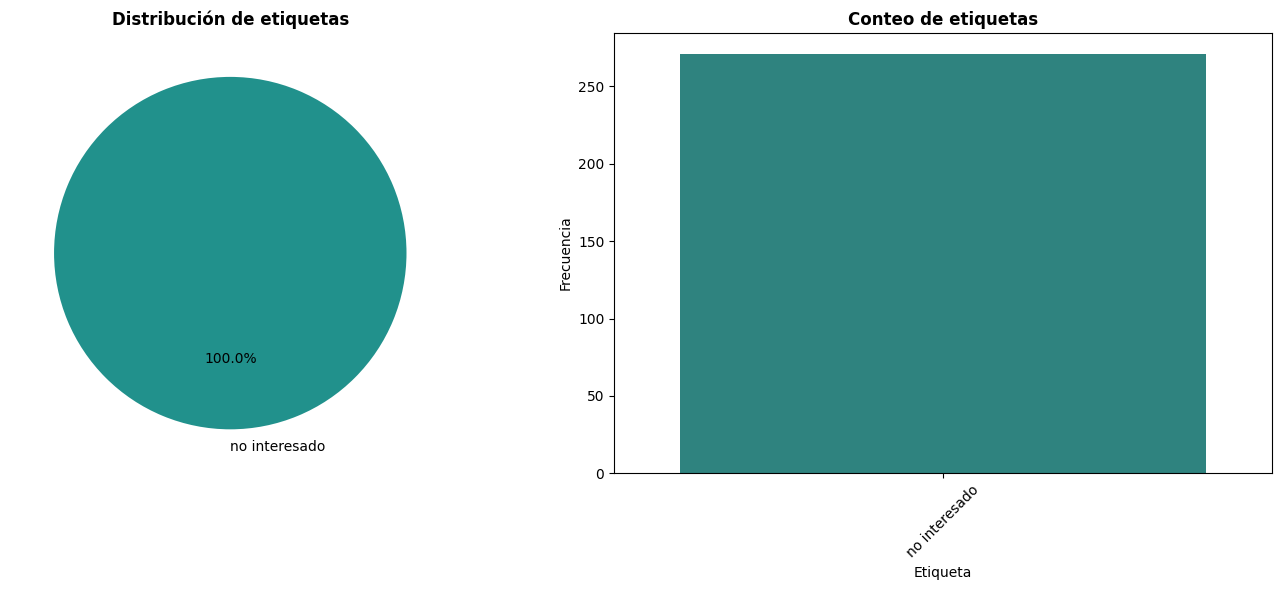

C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


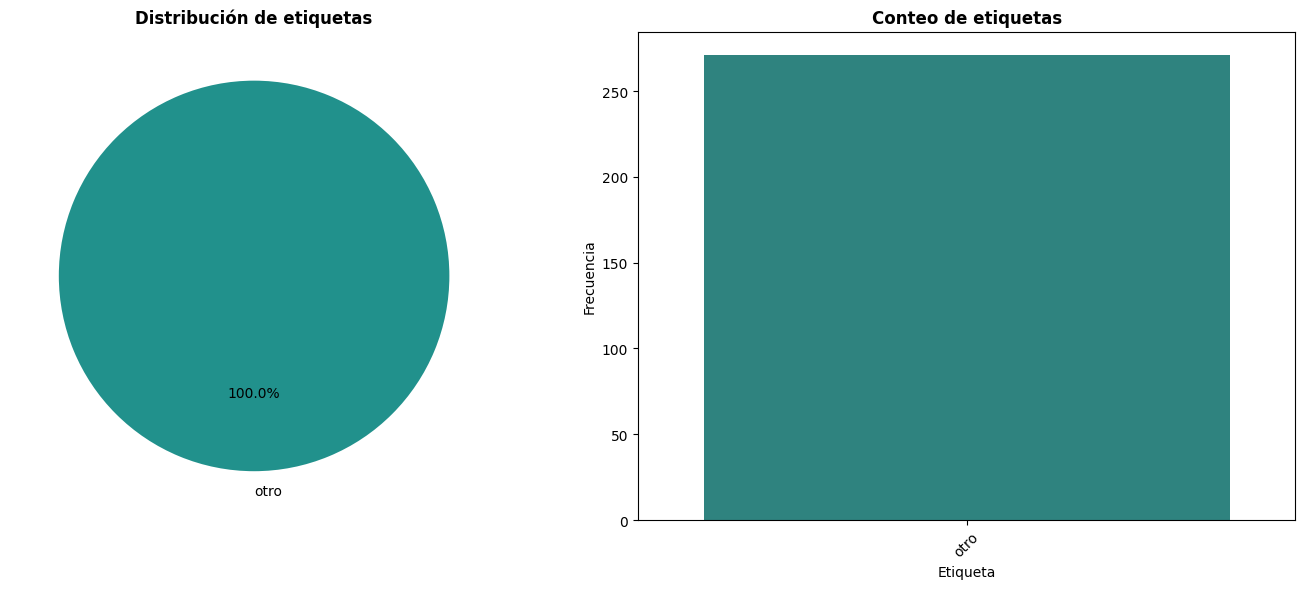

In [87]:
plot_label_distribution_and_pie_chart(df[mask], y_label)
plot_label_distribution_and_pie_chart(df[mask], label_name)

Todas las predicciones "incorrectas" de 'no interesado' las etiquetó como 'otro'

In [88]:
mask = (df['correct'] == False) & (df[label_name] == incorrect_label)

# Visualize the distribution of the 'respuesta' column for the filtered rows
select_random_rows(df[mask][['respuesta', 'preprocessed', y_label, label_name]], n)

index: 461
respuesta: Dormir
preprocessed: dormir
label: otro
label_nb: no interesado
---
index: 7136
respuesta: Gracias saludos buenas noches
preprocessed: gracias saludos buenas noches
label: otro
label_nb: no interesado
---
index: 7706
respuesta: Chingado no entiendes nada
preprocessed: chingado no entiendes nada
label: grosero
label_nb: no interesado
---
index: 24665
respuesta: Dormir
preprocessed: dormir
label: otro
label_nb: no interesado
---
index: 9831
respuesta: Manden lana
preprocessed: manden lana
label: otro
label_nb: no interesado
---


## Improve the model using Undersampling y Class weights

### Undersampling

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

def train_and_predict_undersampled(df, x_label, y_label, label_name='y_pred'):
    # Vectorización del texto
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df[x_label])
    y = df[y_label]

    # Undersampling
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)

    # División
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    # Entrenamiento
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predicciones para todo el conjunto original
    df[label_name] = model.predict(X)
    df['correct'] = df[y_label] == df[label_name]

    # Probabilidades
    probas = model.predict_proba(X)
    df[f'{label_name}_proba'] = probas.max(axis=1)
    for i, class_name in enumerate(model.classes_):
        df[f'proba_{class_name}'] = probas[:, i]

    return df, model, vectorizer, X_train, X_test, y_train, y_test

C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


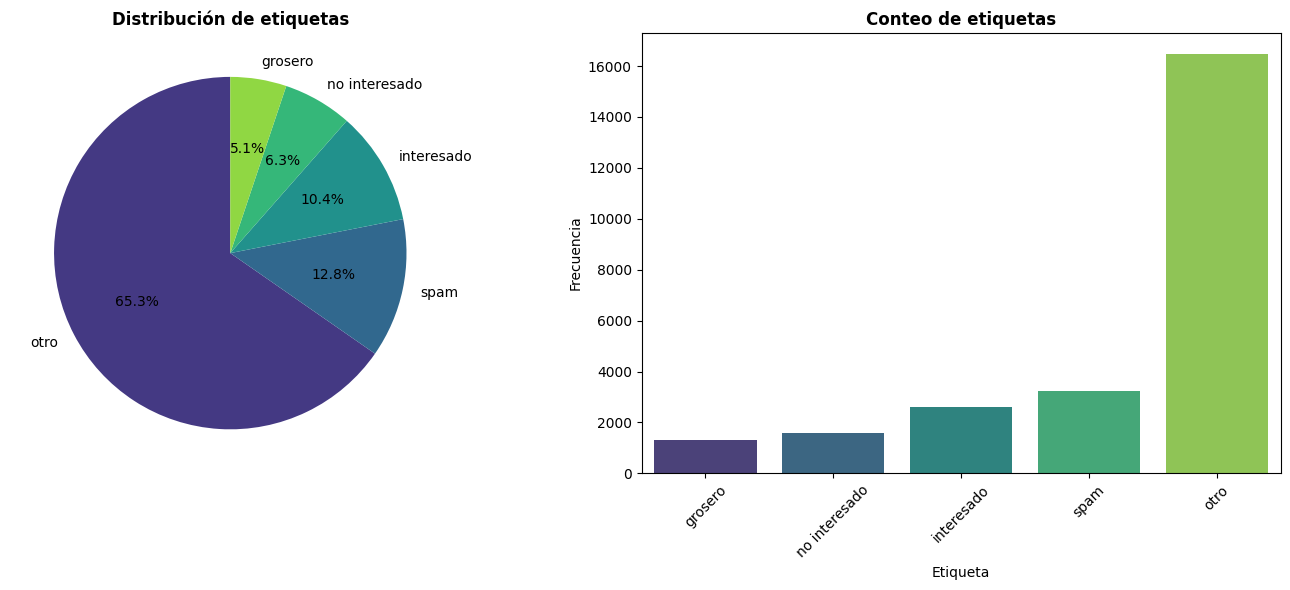

In [90]:
label_name = 'label_nb_undersampled'
y_label = 'label'

# 1. Entrenar y predecir etiquetas usando Naive Bayes con undersampling
df, model, vectorizer, X_train, X_test, y_train, y_test = train_and_predict_undersampled(df, 'preprocessed', y_label, label_name=label_name)
# 2. Seleccionar filas aleatorias para verificar las etiquetas
# select_random_rows(df[['respuesta', 'preprocessed', y_label, label_name]], n)
# 3. Graficar distribución de etiquetas y gráfico de pastel
plot_label_distribution_and_pie_chart(df, label_name) #, ignore_columns=['otro'])

In [91]:
# 4. Seleccionar filas aleatorias para etiquetas específicas
# select_random_rows(df[df[label_name] == 'otro'][['respuesta', y_label, label_name]], n)

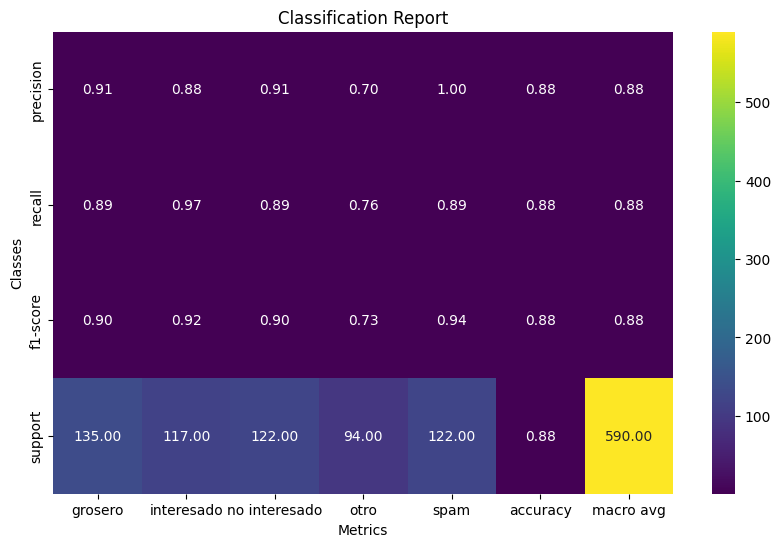

In [92]:
plot_classification_report(y_test=y_test, y_pred=model.predict(X_test), class_names=model.classes_)

La categoría "Otro" disminuye en precisión y recall, pero aumentan las demás, con f1 >= 0.9.

Indica que se reetiquetó la categoría otro con las categorías restantes, posiblemente mejorando el baseline. Se evalúa esto en los siguientes bloques.

In [93]:
incorrect_label = 'no interesado'

mask = (df['correct'] == False) & (df['label'] == incorrect_label)
df[mask].head(5)

,fecha,user,respuesta,preprocessed,label,label_k,label_nb,correct,label_nb_proba,proba_grosero,proba_interesado,proba_no interesado,proba_otro,proba_spam,label_nb_undersampled,label_nb_undersampled_proba
3291,2025-01-28 12:36:08,01JJQ2HE37EVC9NTJM36RDPYTE,Ya dejame,ya dejame,no interesado,1,otro,False,0.924290,0.370026,0.105626,0.353563,0.133854,0.036932,grosero,0.370026
3550,2025-01-28 16:10:32,01JJQET7TNQBSWTBGKSMB78PNC,Mo yadejamee,mo yadejamee,no interesado,1,otro,False,0.778494,0.192797,0.200424,0.198305,0.210169,0.198305,otro,0.210169
3792,2025-01-28 21:42:40,01JJR2CNVF7Z0DSZDP00C5XWEA,Deja.de molestarme,dejade molestarme,no interesado,1,otro,False,0.778494,0.192797,0.200424,0.198305,0.210169,0.198305,otro,0.210169
5454,2025-01-30 15:29:41,01JJWG5BN0QYJ0AFSNZVZAW0C6,Bloquearte,bloquearte,no interesado,1,otro,False,0.778494,0.192797,0.200424,0.198305,0.210169,0.198305,otro,0.210169
5516,2025-01-30 16:29:10,01JJWN8E86R4YR1Z49DZV4AKTM,Bloquearte,bloquearte,no interesado,1,otro,False,0.778494,0.192797,0.200424,0.198305,0.210169,0.198305,otro,0.210169


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


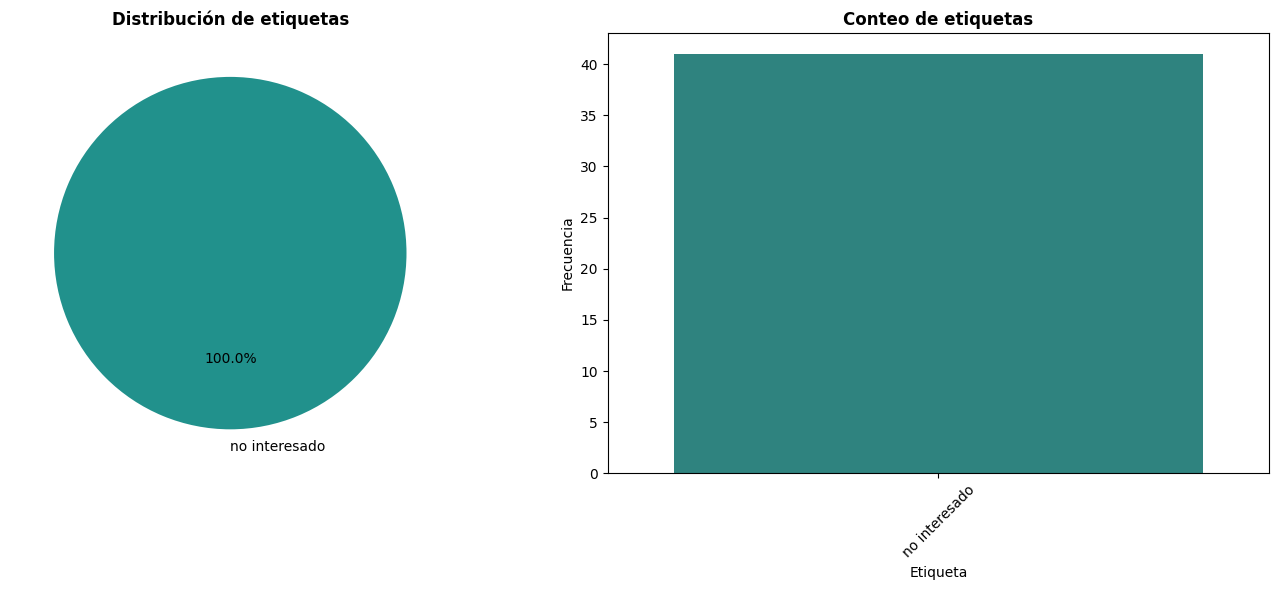

C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


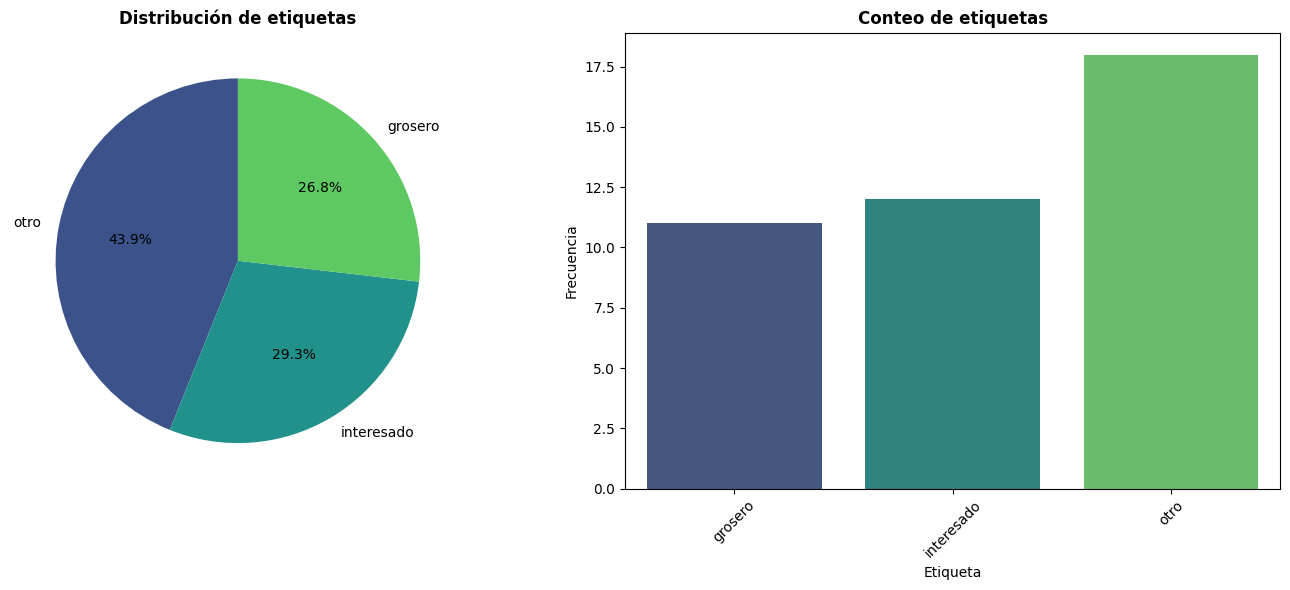

In [94]:
plot_label_distribution_and_pie_chart(df[mask], y_label)
plot_label_distribution_and_pie_chart(df[mask], label_name)

In [95]:
mask = (df['correct'] == False) & (df[label_name] == incorrect_label)

# Visualize the distribution of the 'respuesta' column for the filtered rows
select_random_rows(df[mask][['respuesta', 'preprocessed', y_label, label_name]], n)

index: 8739
respuesta: No
preprocessed: no
label: otro
label_nb_undersampled: no interesado
---
index: 24465
respuesta: Éste ³no ³me
preprocessed: éste no me
label: otro
label_nb_undersampled: no interesado
---
index: 12583
respuesta: No entiende
preprocessed: no entiende
label: otro
label_nb_undersampled: no interesado
---
index: 5530
respuesta: Te voy a demandar
preprocessed: te voy a demandar
label: otro
label_nb_undersampled: no interesado
---
index: 20511
respuesta: Ere32
preprocessed: ere
label: otro
label_nb_undersampled: no interesado
---


En pocas consultas a los datos, un cantidad considerable de etiquetas mejoró.

### Class weights

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

def train_and_predict_weighted(df, x_label, y_label, label_name='y_pred'):
    # Vectorización
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df[x_label])
    y = df[y_label]

    # División
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pesos por clase
    classes = y.unique()
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    weight_dict = dict(zip(classes, class_weights))

    # Modelo con pesos
    model = LogisticRegression(class_weight=weight_dict, max_iter=1000)
    model.fit(X_train, y_train)

    # Predicciones
    df[label_name] = model.predict(X)
    df['correct'] = df[y_label] == df[label_name]

    # Probabilidades
    probas = model.predict_proba(X)
    df[f'{label_name}_proba'] = probas.max(axis=1)
    for i, class_name in enumerate(model.classes_):
        df[f'proba_{class_name}'] = probas[:, i]

    return df, model, vectorizer, X_train, X_test, y_train, y_test


index: 1140
respuesta: Qui
preprocessed: qui
label: otro
label_weighted: otro
---
index: 21
respuesta: No
preprocessed: no
label: otro
label_weighted: otro
---
index: 1844
respuesta: mejor lo escribo
preprocessed: mejor lo escribo
label: otro
label_weighted: otro
---
index: 23501
respuesta: Saladitas para la carne tartara
preprocessed: saladitas para la carne tartara
label: otro
label_weighted: otro
---
index: 13415
respuesta: nfl2025vete ala verga
preprocessed: nflvete ala verga
label: grosero
label_weighted: grosero
---


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


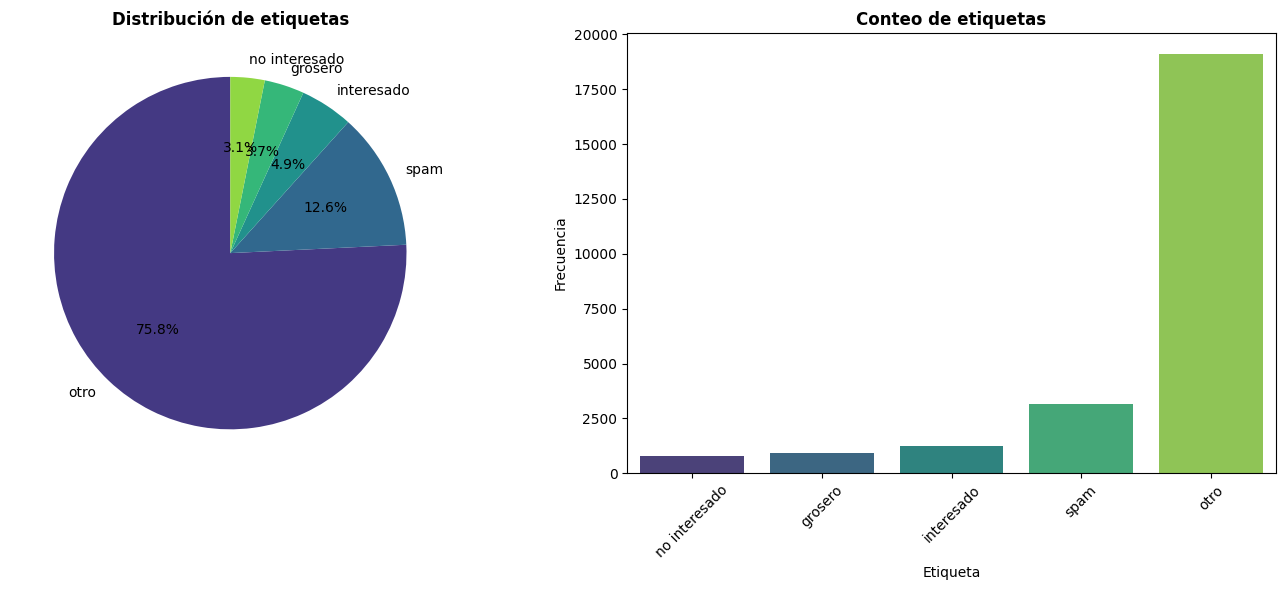

In [97]:
label_name = 'label_weighted'
y_label = 'label'

# 1. Entrenar y predecir etiquetas usando Naive Bayes con undersampling
df, model, vectorizer, X_train, X_test, y_train, y_test = train_and_predict_weighted(df, 'preprocessed', y_label, label_name=label_name)
# 2. Seleccionar filas aleatorias para verificar las etiquetas
select_random_rows(df[['respuesta', 'preprocessed', y_label, label_name]], n)
# 3. Graficar distribución de etiquetas y gráfico de pastel
plot_label_distribution_and_pie_chart(df, label_name) #, ignore_columns=['otro'])

In [98]:
# 4. Seleccionar filas aleatorias para etiquetas específicas
# select_random_rows(df[df[label_name] == 'otro'][['respuesta', y_label, label_name]], n)

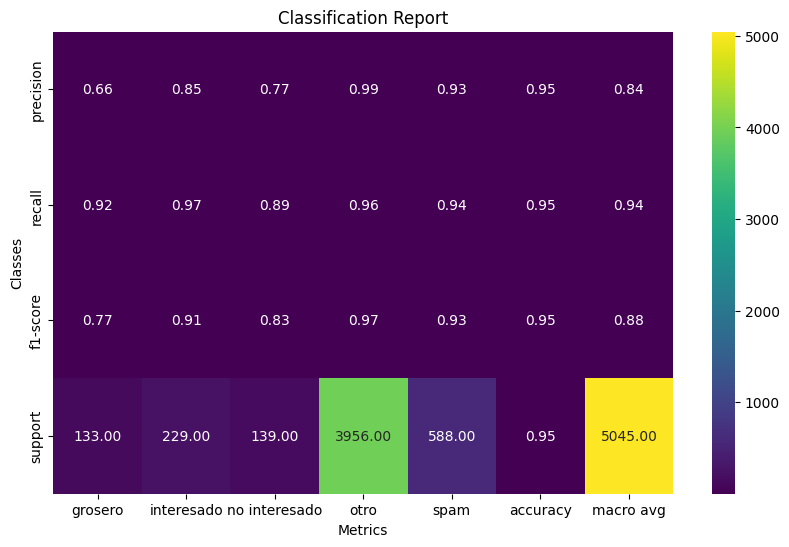

In [99]:
plot_classification_report(y_test=y_test, y_pred=model.predict(X_test), class_names=model.classes_)

In [100]:
incorrect_label = 'otro'

mask = (df['correct'] == False) & (df['label'] == incorrect_label) #& (df['label_weighted_proba'] < .30)
df[mask].head(5)

,fecha,user,respuesta,preprocessed,label,label_k,label_nb,correct,label_nb_proba,proba_grosero,proba_interesado,proba_no interesado,proba_otro,proba_spam,label_nb_undersampled,label_nb_undersampled_proba,label_weighted,label_weighted_proba
34,2025-01-01 19:24:14,01JGJ9F6PQKWB43Y3BNBV5XRVM,Quiero aprovechar este momento para comentarle...,quiero aprovechar este momento para comentarle...,otro,1,otro,False,0.913615,0.026417,0.310156,0.093270,0.276319,0.293838,interesado,0.473774,interesado,0.310156
49,2025-01-01 23:23:53,01J85M3VHASWS4RX06TX4GVBRV,Eres gey?,eres gey,otro,1,otro,False,0.869391,0.399996,0.009732,0.354537,0.219307,0.016429,no interesado,0.761190,grosero,0.399996
85,2025-01-02 05:33:57,01JGKBH1Q86A9KZFN2SDAPSADG,Quiero registrarme,quiero registrarme,otro,1,otro,False,0.721584,0.036273,0.096231,0.799762,0.064084,0.003650,interesado,0.608343,no interesado,0.799762
89,2025-01-02 09:29:05,01JGKT4MTKZ2PQ95XP33BQJHX4,Donde los puedo cobrar?.,donde los puedo cobrar,otro,1,otro,False,0.748828,0.012438,0.680818,0.014095,0.246389,0.046260,interesado,0.520186,interesado,0.680818
198,2025-01-03 15:23:53,01JGQ0NFE6FFCRRVNK6WCDCRH7,En San Miguel Tenextatiloyan,en san miguel tenextatiloyan,otro,1,otro,False,0.637027,0.077218,0.031466,0.054115,0.344453,0.492748,spam,0.635121,spam,0.492748


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


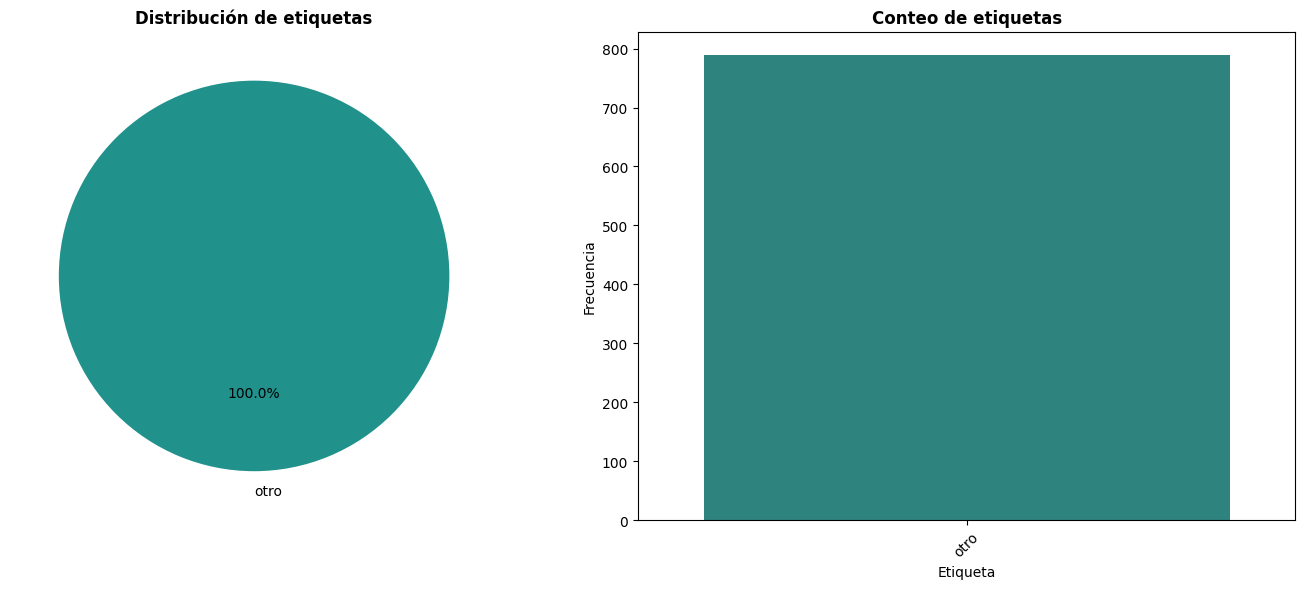

C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


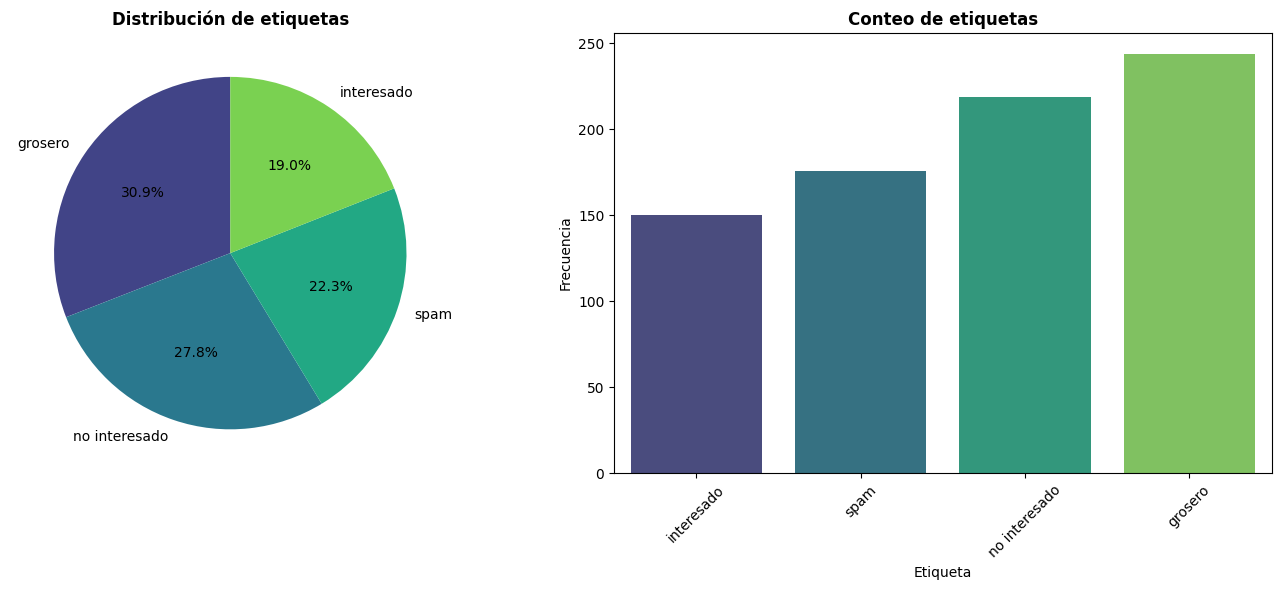

In [101]:
plot_label_distribution_and_pie_chart(df[mask], y_label)
plot_label_distribution_and_pie_chart(df[mask], label_name)

In [102]:
mask = (df['correct'] == False) & (df[label_name] == incorrect_label)

# Visualize the distribution of the 'respuesta' column for the filtered rows
select_random_rows(df[mask][['respuesta', 'preprocessed', y_label, label_name]], n)

index: 16254
respuesta: Cfbgbgbfbgbfbfbfgjgbgbgbgbfbgbgbgbgbgbgbgbfbgbgfbgbggbgbgggbggbggbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbfzfbfbfbfbfbfbzbxbfbfbfbfbffbfffbfbgb..gbggbgbgnjkgbgngbggbgbgbgbgbgbgbgbgbggbgbggbgbgbgbgg
preprocessed: cfbgbgbfbgbfbfbfgjgbgbgbgbfbgbgbgbgbgbgbgbfbgbgfbgbggbgbgggbggbggbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbfzfbfbfbfbfbfbzbxbfbfbfbfbffbfffbfbgbgbggbgbgnjkgbgngbggbgbgbgbgbgbgbgbgbggbgbggbgbgbgbgg
label: spam
label_weighted: otro
---
index: 12801
respuesta: Hsisehwhwhwehgweeheuehwhwsbslwhjwwhhwwhhsnwbwlwhwjwlwllwjwlkebkw vv en vwvwbejwkhvqqc t gwhwwgeuuwwuwgwwhhwh wgiwvwhwgwhwsvshwhw
preprocessed: hsisehwhwhwehgweeheuehwhwsbslwhjwwhhwwhhsnwbwlwhwjwlwllwjwlkebkw vv en vwvwbejwkhvqqc t gwhwwgeuuwwuwgwwhhwh wgiwvwhwgwhwsvshwhw
label: spam
label_weighted: otro
---
index: 17578
respuesta: Holaaaaa
preprocessed: holaaaaa
label: interesado
label_weighted: otro
---
index: 22856
respuesta: Qws4drtctctj ytieiwteiwuwuwqoiqpqiwyepqoqydpquwqpuwoquwpqiwpqiwoquwteiqywqouwoqdhskjdsk

Mejoras en la clasificación de etiquetas

In [103]:
df.head()

,fecha,user,respuesta,preprocessed,label,label_k,label_nb,correct,label_nb_proba,proba_grosero,proba_interesado,proba_no interesado,proba_otro,proba_spam,label_nb_undersampled,label_nb_undersampled_proba,label_weighted,label_weighted_proba
0,2025-01-01 01:48:25,01JFP8JG8DJ5S2MF5G20Y1VKRH,Ya no gracias,ya no gracias,no interesado,1,otro,True,0.926432,0.006682,0.004838,0.957617,0.025990,0.004874,no interesado,0.838648,no interesado,0.957617
1,2025-01-01 02:54:12,01JD2QC03T3R0Q7JVWCC8RJWDT,Estados Unidos y estados miembros y xked Cleme...,estados unidos y estados miembros y xked cleme...,spam,1,spam,True,0.984901,0.014585,0.009227,0.006345,0.059536,0.910307,spam,0.903479,spam,0.910307
2,2025-01-01 02:54:12,01JD2QC03T3R0Q7JVWCC8RJWDT,Estados Unidos y estados miembros y xked Cleme...,estados unidos y estados miembros y xked cleme...,spam,1,spam,True,0.984901,0.014585,0.009227,0.006345,0.059536,0.910307,spam,0.903479,spam,0.910307
3,2025-01-01 02:54:13,01JD2QC03T3R0Q7JVWCC8RJWDT,País donde están los de naciones miembros del ...,país donde están los de naciones miembros del ...,spam,1,spam,True,0.992902,0.002769,0.003279,0.003071,0.013958,0.976923,spam,0.959828,spam,0.976923
4,2025-01-01 02:54:13,01JD2QC03T3R0Q7JVWCC8RJWDT,País donde están los de naciones miembros del ...,país donde están los de naciones miembros del ...,spam,1,spam,True,0.992902,0.002769,0.003279,0.003071,0.013958,0.976923,spam,0.959828,spam,0.976923


## Save csv file

In [104]:
# Save file
df_save = df[['preprocessed', 'label_weighted', 'label_weighted_proba']][df['label_weighted_proba'] >= 0.8]
df_save = df_save.drop_duplicates(subset=['preprocessed'])
# Take only 50 samples for each label
df_save = df_save.groupby('label_weighted').apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)
# df_save.to_excel('df_labels.xlsx', index=False)

C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\3117141081.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_save = df_save.groupby('label_weighted').apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)


## Improve performance with Bert Model

### Training

In [105]:
df_sample_labels = pd.read_excel('df_labels.xlsx')
df_sample_labels.head()

,preprocessed,label_weighted,label_weighted_proba
0,chinga tu madre youtube,grosero,0.975888
1,tu puta madre,grosero,0.998181
2,chinga tu puta madre youtube y tus anuncios,grosero,0.995137
3,te pasas de verga,grosero,0.979112
4,chinga tu puta madre youtube tu y tus anuncios...,grosero,0.882814


In [106]:
df_sample_labels.rename(columns={'label_weighted': 'etiqueta', 'label_weighted_proba': 'proba', 'preprocessed': 'texto'}, inplace=True)
df_sample_labels.head()

,texto,etiqueta,proba
0,chinga tu madre youtube,grosero,0.975888
1,tu puta madre,grosero,0.998181
2,chinga tu puta madre youtube y tus anuncios,grosero,0.995137
3,te pasas de verga,grosero,0.979112
4,chinga tu puta madre youtube tu y tus anuncios...,grosero,0.882814


#### Preprocess dataset

In [107]:
# from datasets import Dataset
# from sklearn.preprocessing import LabelEncoder

# # Encode labels (de texto a int)
# le = LabelEncoder()
# df_sample_labels['label'] = le.fit_transform(df['etiqueta'])

# # Crear dataset de HuggingFace
# dataset = Dataset.from_pandas(df_sample_labels[['texto', 'label']])
# dataset = dataset.train_test_split(test_size=0.2, seed=42)

#### Load Tokenizer and BERT Model (BETO for Spanish)

In [108]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = "dccuchile/bert-base-spanish-wwm-cased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

#### Tokenize dataset

In [109]:
# def tokenize_function(examples):
#     return tokenizer(examples["texto"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(tokenize_function, batched=True)

#### Train Model (Fine-Tuning)

In [110]:
# from transformers import TrainingArguments, Trainer
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Función para evaluar
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
#     acc = accuracy_score(labels, predictions)
#     return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# # Configurar argumentos de entrenamiento
# training_args = TrainingArguments(
#     output_dir="./beto-finetuned",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     logging_dir='./logs',
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=4,
#     weight_decay=0.01,
# )

# # Entrenador
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset["train"],
#     eval_dataset=tokenized_dataset["test"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
# )

# # Entrenamiento
# trainer.train()

#### Evaluate and use model

In [111]:
# # Evaluación
# trainer.evaluate()

# # Predicciones
# preds = trainer.predict(tokenized_dataset["test"])
# y_pred = preds.predictions.argmax(axis=1)
# y_true = tokenized_dataset["test"]["label"]

# from sklearn.metrics import classification_report
# print(classification_report(y_true, y_pred, target_names=le.classes_))

#### Save the Model

In [112]:
# model.save_pretrained("modelo_beto_etiquetado")
# tokenizer.save_pretrained("modelo_beto_etiquetado")

### Import BERT model and tokenizer

In [113]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Carga el modelo y tokenizer desde la carpeta donde lo guardaste
model_path = "./beto-finetuned"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [114]:
import torch
import numpy as np

def predict_label(text, tokenizer, model, label_mapping=None):
    model.eval()
    
    # Tokenizar el texto
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Desactivar gradientes porque es inferencia
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Obtener logits y probabilidades
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred_label = torch.argmax(probs, dim=1).item()
    prob = probs[0][pred_label].item()

    # Si pasaste un mapeo de índices a etiquetas, tradúcelo
    if label_mapping:
        pred_label = label_mapping[pred_label]

    return pred_label, prob

In [115]:
label_mapping = {
    0: "grosero",
    1: "interesado",
    2: "no interesado",
    3: "otro",
    4: "spam"
}

In [116]:
texto = "Mexicanos al grito de guerra"
etiqueta, probabilidad = predict_label(texto, tokenizer, model, label_mapping)

print(f"Predicción: {etiqueta} (confianza: {probabilidad:.2f})")

Predicción: no interesado (confianza: 0.72)


In [117]:
def generate_labels_bert(df, column, label_name, model, tokenizer, label_mapping=None):
    """
    Genera etiquetas para un DataFrame utilizando un modelo BERT preentrenado.
    Usa `.apply()` para mejor performance.
    """
    # Usamos apply con una lambda para extraer pred_label y proba
    results = df[column].apply(lambda text: predict_label(text, tokenizer, model, label_mapping))

    # Separamos los resultados en dos columnas
    df[f'{label_name}_bert'], df[f'{label_name}_bert_proba'] = zip(*results)

    return df

In [ ]:
import torch
from tqdm import tqdm
import numpy as np

def generate_labels_bert_batch(df, column, label_name, model, tokenizer, label_mapping=None, batch_size=32, device=None):
    """
    Genera etiquetas para un DataFrame utilizando un modelo BERT preentrenado con inferencia por lotes.
    """

    # Detectar automáticamente GPU si está disponible
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    model.to(device)

    texts = df[column].tolist()
    all_preds = []
    all_probas = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting with BERT"):
        batch_texts = texts[i:i + batch_size]

        # Tokenización del batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        # Inferencia
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=1)

        # Convertir a NumPy
        all_preds.extend(preds.cpu().numpy())
        all_probas.extend(probs.max(dim=1).values.cpu().numpy())

    # Mapear etiquetas si es necesario
    if label_mapping:
        all_preds = [label_mapping[p] for p in all_preds]

    # Guardar en el DataFrame
    df[f'{label_name}'] = all_preds
    df[f'{label_name}_proba'] = all_probas

    # Correct
    # df['correct'] = df[y_label] == df[label_name]

    return df


In [121]:
df.head()

,fecha,user,respuesta,preprocessed,label,label_k,label_nb,correct,label_nb_proba,proba_grosero,proba_interesado,proba_no interesado,proba_otro,proba_spam,label_nb_undersampled,label_nb_undersampled_proba,label_weighted,label_weighted_proba
0,2025-01-01 01:48:25,01JFP8JG8DJ5S2MF5G20Y1VKRH,Ya no gracias,ya no gracias,no interesado,1,otro,True,0.926432,0.006682,0.004838,0.957617,0.025990,0.004874,no interesado,0.838648,no interesado,0.957617
1,2025-01-01 02:54:12,01JD2QC03T3R0Q7JVWCC8RJWDT,Estados Unidos y estados miembros y xked Cleme...,estados unidos y estados miembros y xked cleme...,spam,1,spam,True,0.984901,0.014585,0.009227,0.006345,0.059536,0.910307,spam,0.903479,spam,0.910307
2,2025-01-01 02:54:12,01JD2QC03T3R0Q7JVWCC8RJWDT,Estados Unidos y estados miembros y xked Cleme...,estados unidos y estados miembros y xked cleme...,spam,1,spam,True,0.984901,0.014585,0.009227,0.006345,0.059536,0.910307,spam,0.903479,spam,0.910307
3,2025-01-01 02:54:13,01JD2QC03T3R0Q7JVWCC8RJWDT,País donde están los de naciones miembros del ...,país donde están los de naciones miembros del ...,spam,1,spam,True,0.992902,0.002769,0.003279,0.003071,0.013958,0.976923,spam,0.959828,spam,0.976923
4,2025-01-01 02:54:13,01JD2QC03T3R0Q7JVWCC8RJWDT,País donde están los de naciones miembros del ...,país donde están los de naciones miembros del ...,spam,1,spam,True,0.992902,0.002769,0.003279,0.003071,0.013958,0.976923,spam,0.959828,spam,0.976923


Predicting with BERT: 100%|██████████| 789/789 [51:44<00:00,  3.93s/it]  
C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


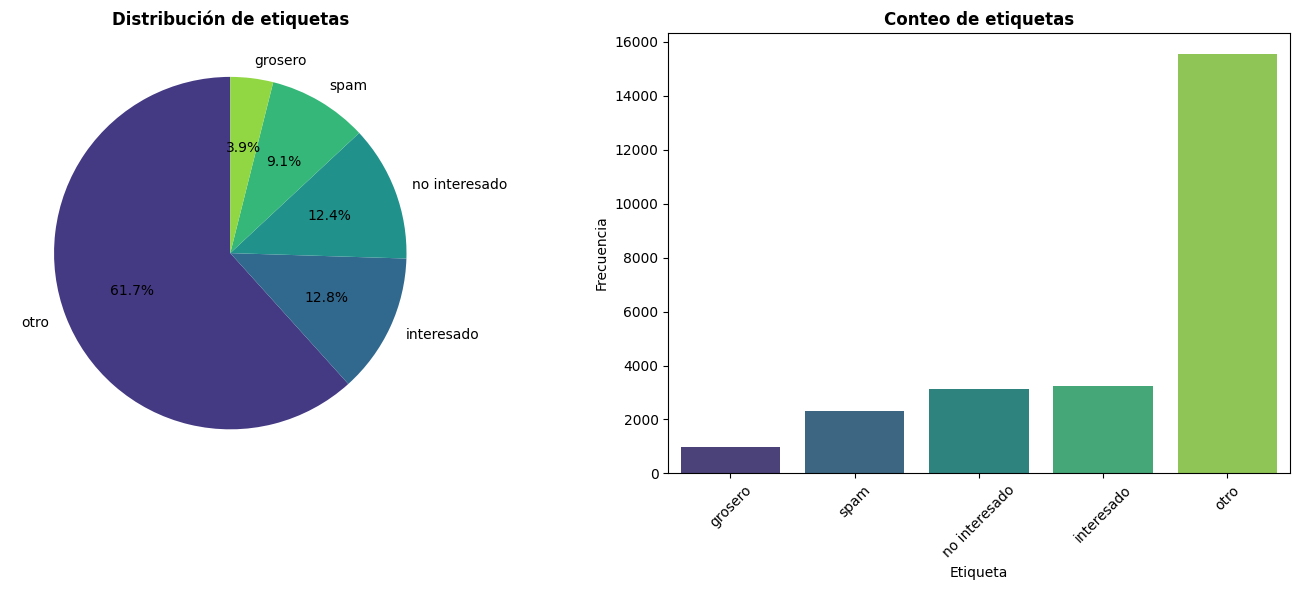

In [ ]:
label_name = 'label_bert'
y_label = 'label'

# 1. Generar etiquetas usando BERT
df = generate_labels_bert_batch(df, 'preprocessed', label_name, model, tokenizer, label_mapping=label_mapping)
# 2. Seleccionar filas aleatorias para verificar las etiquetas
# select_random_rows(df[['respuesta', 'preprocessed', y_label, label_name]], n)
# 3. Graficar distribución de etiquetas y gráfico de pastel
plot_label_distribution_and_pie_chart(df, label_name) #, ignore_columns=['otro'])
df['correct'] = df[y_label] == df[label_name]

In [156]:
# 4. Seleccionar filas aleatorias para etiquetas específicas
select_random_rows(df[df[label_name] == 'interesado'][['respuesta', y_label, label_name]], n)


index: 9886
respuesta: Pero qué sos qué es eso lo que me estás poniendo tú sí sabes que es eso lo que me estás poniendo
label: interesado
label_bert: interesado
---
index: 17222
respuesta: Por favor... ¿Puedes ayudarme a ganar 4 obsequios? Absolutamente sí
https://temu.com/s/DNdBTGzkcMBTjNB
label: spam
label_bert: interesado
---
index: 2425
respuesta: Ya estoy registrado en la app
label: otro
label_bert: interesado
---
index: 18310
respuesta: Quiero mi vaso
label: otro
label_bert: interesado
---
index: 23493
respuesta: telefono de atención a clientes
label: otro
label_bert: interesado
---


In [127]:
# Obtener las clases del modelo BERT
bert_classes = model.config.id2label
print(bert_classes)

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4'}


In [157]:
label_mapping

{0: 'grosero', 1: 'interesado', 2: 'no interesado', 3: 'otro', 4: 'spam'}

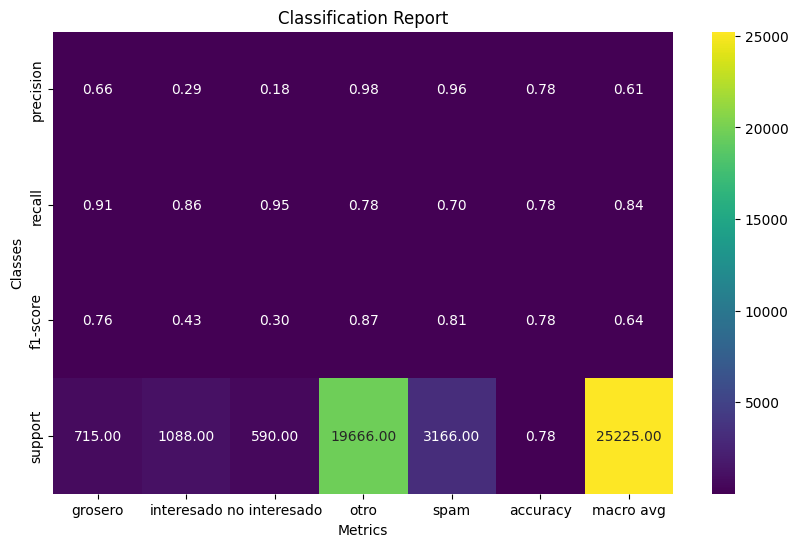

In [163]:
plot_classification_report(y_test=df.label, y_pred=df.label_bert, class_names=label_mapping.values())

In [170]:
incorrect_label = 'interesado'

mask = (df['correct'] == False) & (df['label'] == incorrect_label) #& (df['label_weighted_proba'] < .30)
df[mask].head(5)

,fecha,user,respuesta,preprocessed,label,label_k,label_nb,correct,label_nb_proba,proba_grosero,proba_interesado,proba_no interesado,proba_otro,proba_spam,label_nb_undersampled,label_nb_undersampled_proba,label_weighted,label_weighted_proba,label_bert,label_bert_proba
37,2025-01-01 20:26:06,01JGJD8EWB875YXE3NWMCBEDMP,Listo,listo,interesado,1,interesado,False,0.761604,0.004457,0.975005,0.002460,0.015182,0.002896,interesado,0.615730,interesado,0.975005,otro,0.771128
93,2025-01-02 09:58:00,01JGKVPRHJ4F04G947KNMY0TSD,Listo,listo,interesado,1,interesado,False,0.761604,0.004457,0.975005,0.002460,0.015182,0.002896,interesado,0.615730,interesado,0.975005,otro,0.771128
111,2025-01-02 15:35:47,01JGMF235Y6X37D5626R2C2FRF,Chochola Yucatán,chochola yucatán,interesado,1,otro,False,0.778494,0.073635,0.045125,0.027794,0.823599,0.029847,otro,0.210169,otro,0.823599,otro,0.887065
173,2025-01-03 12:02:59,01JGPN7E6SF7BGTB3PPHK9W906,Listo,listo,interesado,1,interesado,False,0.761604,0.004457,0.975005,0.002460,0.015182,0.002896,interesado,0.615730,interesado,0.975005,otro,0.771128
174,2025-01-03 12:02:59,01JGPN7E6SF7BGTB3PPHK9W906,Listo,listo,interesado,1,interesado,False,0.761604,0.004457,0.975005,0.002460,0.015182,0.002896,interesado,0.615730,interesado,0.975005,otro,0.771128


C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


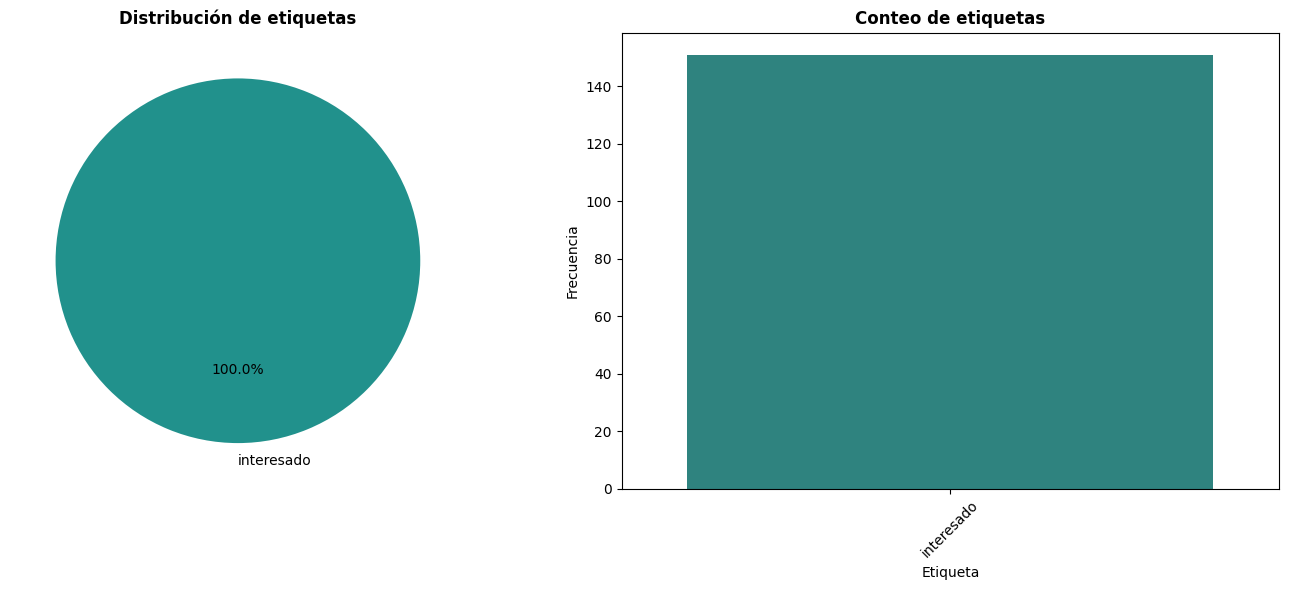

C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\4097065363.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=label_column, order=order, palette='viridis', ax=axes[1])


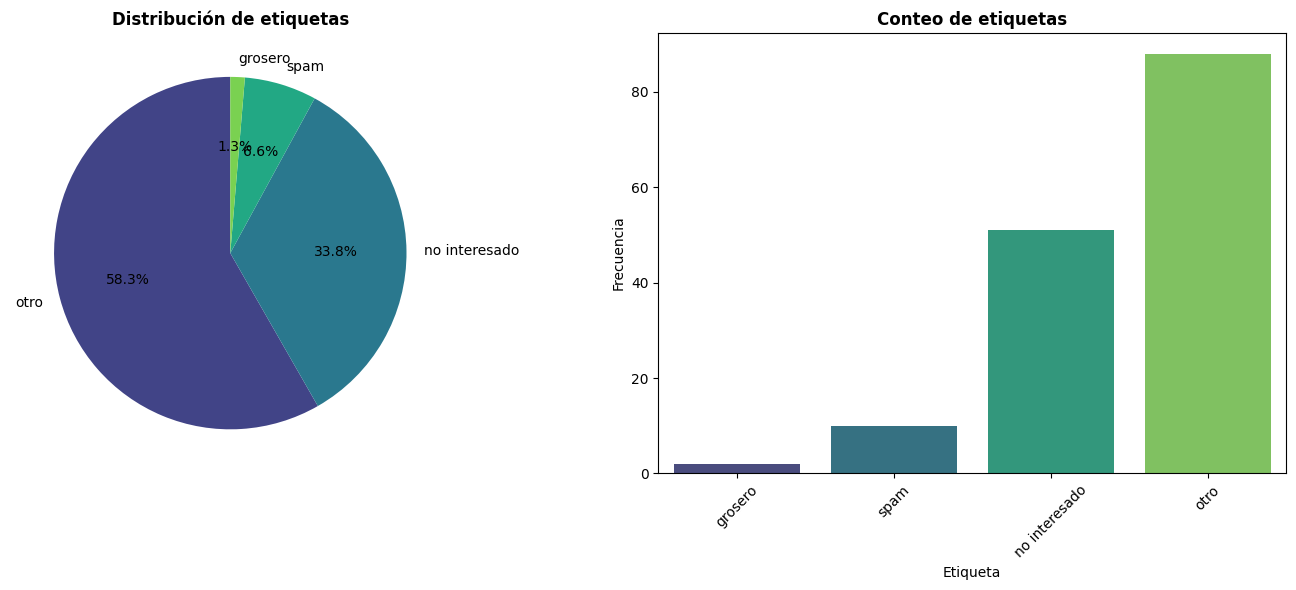

In [171]:
plot_label_distribution_and_pie_chart(df[mask], y_label)
plot_label_distribution_and_pie_chart(df[mask], label_name)

In [178]:
mask = (df['correct'] == False) & (df[label_name] == incorrect_label)

# Visualize the distribution of the 'respuesta' column for the filtered rows
select_random_rows(df[mask][['respuesta', 'preprocessed', y_label, label_name]], n)

index: 15286
respuesta: U te iba a decir que tenemos una tarea porque mañana tenemos que llevar para las casas pues para las casas de multiplicaciones
preprocessed: u te iba a decir que tenemos una tarea porque mañana tenemos que llevar para las casas pues para las casas de multiplicaciones
label: spam
label_bert: interesado
---
index: 3044
respuesta: L J N W J Y C D M 8 H


Ese es mi código
preprocessed: l j n w j y c d m  hese es mi código
label: otro
label_bert: interesado
---
index: 1573
respuesta: ¿Puedes aceptar mi invitación para que consiga yo un regalo?
https://temu.com/s/bMxu9IbS5i1JKFR2
preprocessed: puedes aceptar mi invitación para que consiga yo un regalourl
label: spam
label_bert: interesado
---
index: 12240
respuesta: Oye eres joy pay
preprocessed: oye eres joy pay
label: otro
label_bert: interesado
---
index: 4594
respuesta: Muchacho mujer
preprocessed: muchacho mujer
label: otro
label_bert: interesado
---


## Save data into BigQuery

In [179]:
import pandas as pd
import google.auth.transport.requests

from google.oauth2 import service_account
from pandas_gbq import read_gbq

In [180]:
# Path to your service account key file
key_path = r"C:\Users\ricjar\Documents\json_credentials.txt"

# Create a credentials object
credentials = service_account.Credentials.from_service_account_file(key_path)

In [181]:
# Your project ID
project_id = 'test-discovery-sybxsf'

# Insertar en BigQuery: wavy-business-analytics.pepsico.homologacion_flujos
df.to_gbq(
    destination_table='wavy-business-analytics.pepsico.sentiment_analysis',
    project_id=project_id,
    credentials=credentials,
    if_exists='replace',
    # progress_bar_type='tqdm',
    chunksize=10000
)

C:\Users\ricjar\AppData\Local\Temp\ipykernel_21796\3744843069.py:5: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 241.16it/s]
